In [ ]:
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from skimage.util import img_as_ubyte
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imsave
#from keras import optimizers

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
from keras.models import model_from_json
#KERAS
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# mlp for the circles problem with hinge loss
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import where

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
from tensorflow.python.framework import ops
ops.reset_default_graph()
#KERAS
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from skimage.util import img_as_ubyte
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import glob
import keras
#from keras.layers.core import Layer
#import keras.backend as K
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten, UpSampling2D
import numpy as np 
import math 
from keras.callbacks import LearningRateScheduler
import os
import skimage.io as io
import skimage.transform as trans
import skimage.data
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import cv2



#DATA AUGMENTATION
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')



def adjustData(img,mask,flag_multi_class,num_class):
  if(flag_multi_class):
    img = img / 255
    mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
    new_mask = np.zeros(mask.shape + (num_class,))
    for i in range(num_class):
      #for one pixel in the image, find the class in mask and convert it into one-hot vector
      #index = np.where(mask == i)
      #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
      #new_mask[index_mask] = 1
      new_mask[mask == i,i] = 1
      new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
      mask = new_mask
  elif(np.max(img) > 1):
      img = img / 255
      mask = mask / 255
      mask[mask > 0.5] = 1
      mask[mask <= 0.5] = 0
  return (img,mask)

def trainGenerator(batch_size,train_path,image_folder_train,mask_folder_train,
                   data_gen_args,image_color_mode = "grayscale",
                   mask_color_mode = "grayscale",image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,num_class = 2,save_to_dir = None,
                   target_size = (256,256),seed = 1):
  image_datagen_train = ImageDataGenerator(**data_gen_args)
  mask_datagen_train = ImageDataGenerator(**data_gen_args)
    
  image_generator_train = image_datagen_train.flow_from_directory(
train_path,
classes = [image_folder_train],
class_mode = None,
color_mode = image_color_mode,
target_size = target_size,
batch_size = batch_size,
save_to_dir = save_to_dir,
save_prefix  = image_save_prefix,
seed = seed)
  
  mask_generator_train = mask_datagen_train.flow_from_directory(train_path,classes = [mask_folder_train],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
  train_generator = zip(image_generator_train, mask_generator_train)
  for (img,mask) in train_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)

def valGenerator(batch_size,train_path,
                 image_folder_val,mask_folder_val,
                 data_gen_args,image_color_mode = "grayscale",
                 mask_color_mode = "grayscale",image_save_prefix  = "image",
                 mask_save_prefix  = "mask",
                 flag_multi_class = False,num_class = 2, save_to_dir = None,
                 target_size = (256,256),seed = 1):
  image_datagen_val = ImageDataGenerator(**data_gen_args)
  mask_datagen_val = ImageDataGenerator(**data_gen_args)


  image_generator_val = image_datagen_val.flow_from_directory(
        train_path,
        classes = [image_folder_val],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
  mask_generator_val = mask_datagen_val.flow_from_directory(
        train_path,
        classes = [mask_folder_val],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
  val_generator = zip(image_generator_val, mask_generator_val)
  for (img,mask) in val_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)



def testGenerator(test_path, num_image, target_size = (256,256), flag_multi_class = False,as_gray = True):
    for i in range(num_image):
      img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
      img = img / 255
      img = trans.resize(img,target_size)
      img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
      img = np.reshape(img,(1,)+img.shape)
      yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
  image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
  image_arr = []
  mask_arr = []
  for index,item in enumerate(image_name_arr):
    img = io.imread(item,as_gray = image_as_gray)
    img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
    mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
    mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    image_arr.append(img)
    mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
  img = img[:,:,0] if len(img.shape) == 3 else img
  img_out = np.zeros(img.shape + (3,))
  for i in range(num_class):
    img_out[img == i,:] = color_dict[i]
    return img_out / 255
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
  for i,item in enumerate(npyfile):
    img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
    cv2.imwrite(os.path.join(save_path,"%d_predict.png"%i),img_as_ubyte(img))
    #io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

def dice_coef(label, results):
  y_true_f = K.flatten(label)
  y_pred_f = K.flatten(results)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def jaccard_distance(label, results, smooth=100):
  intersection = K.sum(K.abs(label * results), axis=-1)
  sum_ = K.sum(K.abs(label) + K.abs(results), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return (1 - jac) * smooth        

def down_block(x, filters, kernel_size=(3,3), padding = "same", strides=1):
  c = tf.keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(x)
  c = tf.keras.layers.BatchNormalization()(c)
  c1c = tf.keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
  p = tf.keras.layers.MaxPool2D((2,2),(2,2))(c1c)
    
  return c, p

def up_block(x, skip, filters, kernel_size=(3,3), padding = "same", strides=1):
  us = tf.keras.layers.UpSampling2D((2,2))(x)
  concat = tf.keras.layers.Concatenate()([us, skip])
  c = tf.keras.layers.BatchNormalization()(concat)
  c = tf.keras.layers.Conv2DTranspose(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(concat)
  c = tf.keras.layers.Conv2DTranspose(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
  return c

def bottelneck(x, filters, kernel_size=(3,3), padding = "same", strides=1):
  c = tf.keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(x)
  c = tf.keras.layers.Conv2D(filters, kernel_size, padding = padding, strides = strides, activation = "relu")(c)
  return c

####################################################End of Different Convolutional Blocks ###############################################
    
#################################################### U-NET Model ########################################################################    
    
def Unet():
  f = [16, 32, 64, 128, 256] ####feature maps, No. of Filters
  image_size= 256
    #droprate = 0.5
  inputs = tf.keras.layers.Input((image_size, image_size, 1)) #####Input to the Model
    
  p0 = inputs  
    ##### Input is assigned to p0 
    ######Downsampling the Images                                     
  c1, p1 = down_block(p0, f[0])  #### 128 ---> 64
  c1 = tf.keras.layers.Dropout(0.5)(c1)

  c2, p2 = down_block(p1, f[1])  #### 64----> 32
  c2 = tf.keras.layers.Dropout(0.5)(c2)

  c3, p3 = down_block(p2, f[2])  #### 32---> 16
  c3 = tf.keras.layers.Dropout(0.5)(c3)

  c4, p4 = down_block(p3, f[3])  #### 16----> 8
  c4 = tf.keras.layers.Dropout(0.5)(c4)

  c5, p5 = down_block(p4, f[4])  #### 16----> 8
  c5 = tf.keras.layers.Dropout(0.5)(c5)

    
  bn = bottelneck(p5, f[4])    
    
    ######Upsampling the Images                                     
  u1 = up_block(bn, c5, f[4])
  u1 = tf.keras.layers.Dropout(0.5)(u1)

  u2 = up_block(u1, c4, f[3])
  u2 = tf.keras.layers.Dropout(0.5)(u2)


  u3 = up_block(u2, c3, f[2])
  u3 = tf.keras.layers.Dropout(0.5)(u3)

  u4 = up_block(u3, c2, f[1])
  u4 = tf.keras.layers.Dropout(0.5)(u4)

  u5 = up_block(u4, c1, f[0])  
  u5 = tf.keras.layers.Dropout(0.5)(u5)
    
    #########output Layer
  outputs = tf.keras.layers.Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(u5)
    
    ########preparation of Model
  model = tf.keras.models.Model(inputs, outputs)
    
#    from keras import optimizers
    #import keras.backend as K
  sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
    #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    #model.compile(optimizer = adam1, loss = "binary_crossentropy", metrics = ["acc"])
   
  model.compile(optimizer= sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
  model.summary()

  return model
#################################################### End of U-NET Model #################################################################    

train_path = "/content/drive/MyDrive/Minita/"
image_folder_train = "image_folder_train" 
mask_folder_train =  "mask_train"
image_folder_val = "image_val" 
mask_folder_val =  "mask_val"

#augmentaed_images_train = "D:/train_test_convert/Inception/Inception/Inception/New_Train/Auggmented_Images_train"
#augmentaed_images_val = "D:/train_test_convert/Inception/Inception/Inception/New_Train/Auggmented_Images_val"

batch_size = 4
steps_per_epoch = 76#TotalTrainingSamples / TrainingBatchSize
epochs = 100
#period = 3
validation_steps = 29   #TotalvalidationSamples / ValidationBatchSize


print("*****************Started Training******************")

myGene_train = trainGenerator(batch_size, train_path, image_folder_train, mask_folder_train,
                              data_gen_args, save_to_dir = None)

myGene_val   = valGenerator(batch_size, train_path, image_folder_val, mask_folder_val,
                            data_gen_args, save_to_dir = None)

model = Unet()

H=model.fit(myGene_train,
                      steps_per_epoch = steps_per_epoch,
                      epochs = epochs, 
                      validation_data = myGene_val,
                      validation_steps = validation_steps)
print("Saving the Model.........................")
model.save('/content/drive/MyDrive/Minita/Model/minita.h5')
print("Model Saved in Drive......................")


*****************Started Training******************
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
__________________________________________

ValueError: ignored

In [ ]:
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from skimage.util import img_as_ubyte
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imsave
#from keras import optimizers

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
from keras.models import model_from_json
#KERAS
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# mlp for the circles problem with hinge loss
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import where

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image
from tensorflow.python.framework import ops
ops.reset_default_graph()
#KERAS
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from skimage.util import img_as_ubyte
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import glob
import keras
#from keras.layers.core import Layer
#import keras.backend as K
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten, UpSampling2D
import numpy as np 
import math 
from keras.callbacks import LearningRateScheduler
import os
import skimage.io as io
import skimage.transform as trans
import skimage.data
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import cv2


def testGenerator(test_path, num_image, target_size = (256,256), flag_multi_class = False,as_gray = True):
    for i in range(num_image):
      img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
      img = img / 255
      img = trans.resize(img,target_size)
      img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
      img = np.reshape(img,(1,)+img.shape)
      yield img



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
  for i,item in enumerate(npyfile):
    img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
    cv2.imwrite(os.path.join(save_path,"%d_predict.png"%i),img_as_ubyte(img))
    #io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)





print("Loading saved Model")
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Minita/Model/Model_Mammo_400_epochs_SGD_Optimizer.h5")
test_images = 28
test_path = "/content/drive/MyDrive/Minita/test_images"
Predicted_path = "/content/drive/MyDrive/Minita/preds_minita"
test_label = "/content/drive/MyDrive/Minita/minita"
print("testing images on model.............")
H1=testGenerator(test_path,test_images)
results = loaded_model.predict_generator(H1,test_images,verbose=1)
print("Predicted images saved.......")
saveResult(Predicted_path,results)


Loading saved Model
testing images on model.............


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


28/28 [==============================] - 29s 1s/step
Predicted images saved.......


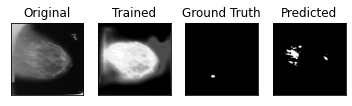

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

og = cv2.imread('/content/drive/MyDrive/Minita/test_images/22.png')
og=cv2.resize(og, (256,256))
img = cv2.imread('/content/drive/MyDrive/Minita/preds_minita/22_predict.png',0)
ret,thresh1 = cv2.threshold(img,16,255,cv2.THRESH_BINARY)
gt = cv2.imread('/content/drive/MyDrive/Minita/Ground_Truth/Ground_Truth (22).png',0)

img2 = cv2.resize(gt, (256,256))

titles = ['Original','Trained','Ground Truth','Predicted']
images = [og,img, img2, thresh1]


for i in range(4):
    plt.subplot(1,4,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [ ]:
#Calculating DSC & IOU/Jaccard Coefficients
import numpy as np
import cv2
from sklearn.metrics import jaccard_similarity_score
import keras.backend as K

true = cv2.imread('/content/drive/MyDrive/dice_coef/1.jpeg')
pred = cv2.imread('/content/drive/MyDrive/dice_coef/2.jpeg')
print('Original Dimensions : ',pred.shape)

width = 256
height = 256
dim = (width, height)
  
# resize image
true = cv2.resize(true, dim, interpolation = cv2.INTER_AREA)

print('Resized Dimensions : ',true.shape)

pred = cv2.resize(pred, dim, interpolation = cv2.INTER_AREA)


print('Resized Dimensions : ',pred.shape)

def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, :, j], y_pred_bin[i, :, j])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel

print("The Dice Coefficient is: ",mean_dice_coef(true, pred))

true=np.array(true).ravel()
pred=np.array(pred).ravel()
iou = jaccard_similarity_score(true, pred)

print("The IOU/Jaccard Coefficient is: ",iou)





 





Original Dimensions :  (256, 256, 3)
Resized Dimensions :  (256, 256, 3)
Resized Dimensions :  (256, 256, 3)
The Dice Coefficient is:  0.8272399969403018
The IOU/Jaccard Coefficient is:  0.98992919921875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [ ]:
'''import glob
import cv2
import os

count=0
for img in glob.glob("/content/drive/MyDrive/Minita/preds_minita/*.png"):
  
  filename = img
  path = "/content/drive/MyDrive/Minita/binary_minita" 
  img = cv2.imread(img)
  ret, bw_img = cv2.threshold(img,15,255,cv2.THRESH_BINARY)
  cv2.imwrite(os.path.join(path , 'binary%d.png'%count), bw_img)
  count=count+1'''

  

  


  




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
